In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Read Data**

In [2]:
import pandas as pd

dataset=pd.read_csv("/content/gdrive/My Drive/LSTM/name_gender.csv")
data=dataset.values

n_samples=data.shape[0]-1 #delete the last row, because it will not help.
used_data=data[:n_samples,:2] 
print("Used data has shape : ",used_data.shape)
print("Let's show some samples : \n",used_data[:5])

Used data has shape :  (95025, 2)
Let's show some samples : 
 [['Aaban' 'M']
 ['Aabha' 'F']
 ['Aabid' 'M']
 ['Aabriella' 'F']
 ['Aada' 'F']]


# **Label from 'M'/'F' to 0 / 1**

In [3]:
import numpy as np

m_idx=np.where(used_data[:,1]=='M')
f_idx=np.where(used_data[:,1]=='F')
used_data[m_idx,1]=0
used_data[f_idx,1]=1
print("Let's look some samples after converting gender labels : ",used_data[:5])

Let's look some samples after converting gender labels :  [['Aaban' 0]
 ['Aabha' 1]
 ['Aabid' 0]
 ['Aabriella' 1]
 ['Aada' 1]]


# **Define dictionary**

In [4]:
import string

all_letters=string.ascii_letters # a,b,c,d.....z,A,B,C,D,...,Z
dictionary=all_letters[:26] # only need lowercase letter
print("Dictionary : ",dictionary)
print("Length of dictionary : ",len(dictionary))


Dictionary :  abcdefghijklmnopqrstuvwxyz
Length of dictionary :  26


# **Convert name to torch tensor with one-hot encoding method**

In [5]:
import torch

n_letters=len(dictionary) #length of dict =26

def name_to_tensor(name):
  name=name.lower()
  tensor=torch.zeros(len(name),1,n_letters) #each letter is an one-hot vector
  for idx,letter in enumerate(name):
    letter_idx=dictionary.find(letter)
    tensor[idx][0][letter_idx]=1
  return tensor

#test an example
print("Tensor for name : 'Hieu' : \n",name_to_tensor("Hieu"))
print(name_to_tensor("Hieu").shape,"\n")


Tensor for name : 'Hieu' : 
 tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0.]]])
torch.Size([4, 1, 26]) 



# **Split Dataset**

In [6]:
#split
import numpy as np
from sklearn.model_selection import train_test_split

n_samples=len(used_data)
idx_range=np.arange(n_samples) # Get the index from 0 to 95024 
#np.random.shuflle(idx_range) #shuffle index

X_train,X_test_val,y_train,y_test_val=train_test_split(used_data[:,0],used_data[:,1],test_size=0.2) 
X_val,X_test,y_val,y_test=train_test_split(X_test_val,y_test_val,test_size=0.5)

print("Shape of X_train , y_train : ",X_train.shape,y_train.shape)
print("Shape of X_val, y_val : ",X_val.shape,y_val.shape)
print("Shape of X_test, y_test : ",X_test.shape, y_test.shape)

Shape of X_train , y_train :  (76020,) (76020,)
Shape of X_val, y_val :  (9502,) (9502,)
Shape of X_test, y_test :  (9503,) (9503,)


# **Function to load data while training**

In [7]:
from torch.autograd import Variable 

def get_data_pair(X,y,idx):
  X_=Variable(name_to_tensor(X[idx]))
  y_=Variable(torch.tensor([y[idx]]).long())
  return X_,y_

#test an example : 
print(X_train[100],y_train[100])
print("shape X_train_tensor at 100 : ",get_data_pair(X_train,y_train,100)[0].shape)
print("y_train_tensor at 100 : ",get_data_pair(X_train,y_train,100)[1].shape) 


Srivar 0
shape X_train_tensor at 100 :  torch.Size([6, 1, 26])
y_train_tensor at 100 :  torch.Size([1])


# **Define Model and send it to gpu**

In [8]:
#Apply for natural language model
import torch
import torch.nn as nn

#hidden_size =64
#feature_length=26
#=> concatenated size = 64+26=90
class LSTM(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(LSTM,self).__init__()
    self.input_size=input_size #feature length of inputs ( Note that : inputs != input)
    self.hidden_size=hidden_size
    self.output_size=output_size
    
    #ft
    self.neuralNet_f=nn.Linear(90,64)

    #it
    self.neuralNet_i=nn.Linear(90,64)

    #ct
    self.neuralNet_c=nn.Linear(90,64)

    #ot
    self.neuralNet_o=nn.Linear(90,64)

    #logits
    self.logits=nn.Linear(64,2)
    self.softmax=nn.LogSoftmax()
  
  def forward(self,inputs):
    sequence_length=inputs.size()[0]

    h_t=torch.zeros((1,self.hidden_size))
    c_t=torch.zeros((1,self.hidden_size))

    for input_index_t in range(sequence_length):
      x_t=inputs[input_index_t]
      cat_t=torch.cat((x_t,h_t),1)

      #ft
      f_t=torch.sigmoid(self.neuralNet_f(cat_t))
      
      #it
      i_t=torch.sigmoid(self.neuralNet_i(cat_t))

      #c~t (sign as gt)
      g_t=torch.tanh(self.neuralNet_c(cat_t))

      #ot
      o_t=torch.sigmoid(self.neuralNet_o(cat_t))

      #C_t
      c_t=f_t*c_t+i_t*g_t
      
      #h_t
      h_t=o_t*torch.tanh(c_t)

      #output
      output=self.logits(h_t)
      output=nn.LeakyReLU(0.02)(output)
      output=self.softmax(output)

    return h_t,c_t,output

n_letters=len(dictionary)
lstm=LSTM(26,64,2)

# **Define loss and  optimizer**

In [9]:
criterion=nn.NLLLoss()
learning_rate=0.001
optimizer=torch.optim.SGD(lstm.parameters(),lr=learning_rate)


In [10]:
def train(name_tensor,class_tensor):
  lstm.zero_grad()
  output=lstm(name_tensor)[2]
  loss=criterion(output,class_tensor)
  loss.backward()
  optimizer.step()
  return output,loss.item()

In [11]:
epochs = 10
print_steps=1000
print_all_steps=75000
indices_train=np.arange(len(X_train))
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]

def evaluate(X,y):
  loss=0
  correct=0
  for i in range(len(X)):
    name_tensor,class_tensor=get_data_pair(X,y,i)
    predicted=lstm(name_tensor)[2]
    loss+=criterion(predicted,class_tensor)
    idx_predicted=torch.max(predicted.data,1)[1]
    correct+=(idx_predicted==class_tensor).sum()
  return loss/len(X),correct.item()/len(X)*100


for epoch in range(epochs):
  train_loss=0
  np.random.shuffle(indices_train)
  for i,idx in enumerate(indices_train):
    name_tensor,class_tensor=get_data_pair(X_train,y_train,idx)
    output,loss=train(name_tensor,class_tensor)
    train_loss+=loss
    if(i%print_steps==0 and i>0 and i%print_all_steps !=0):
      print("Iter :",i,"at epoch: ",epoch+1,"/ ",epochs," Train Loss : ",train_loss/print_steps)
      train_loss=0
    elif(i%print_all_steps==0 and i>0):
      with torch.no_grad():

        train_acc=evaluate(X_train,y_train)[1] #Calculate acc for all
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss/print_steps) #calculate loss after "print_steps" training samples and get mean
        
        val_loss,val_acc=evaluate(X_val,y_val)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        print("Iter: ",i,"at epoch: ",epoch+1,"/",epochs," train loss :",train_loss/print_steps,"Train acc: ",train_acc," val loss: ",val_loss," val acc: ",val_acc)
        train_loss=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iter : 1000 at epoch:  1 /  10  Train Loss :  0.6939919663667679
Iter : 2000 at epoch:  1 /  10  Train Loss :  0.6930539111495018
Iter : 3000 at epoch:  1 /  10  Train Loss :  0.6895568848252297
Iter : 4000 at epoch:  1 /  10  Train Loss :  0.6758558031320572
Iter : 5000 at epoch:  1 /  10  Train Loss :  0.6633740720748902
Iter : 6000 at epoch:  1 /  10  Train Loss :  0.6556526923179626
Iter : 7000 at epoch:  1 /  10  Train Loss :  0.6500881291329861
Iter : 8000 at epoch:  1 /  10  Train Loss :  0.6536449889540672
Iter : 9000 at epoch:  1 /  10  Train Loss :  0.6503292200565338
Iter : 10000 at epoch:  1 /  10  Train Loss :  0.6512006373107433
Iter : 11000 at epoch:  1 /  10  Train Loss :  0.6531001300513745
Iter : 12000 at epoch:  1 /  10  Train Loss :  0.645011263370514
Iter : 13000 at epoch:  1 /  10  Train Loss :  0.6566026080846786
Iter : 14000 at epoch:  1 /  10  Train Loss :  0.6318392823338509
Iter : 15000 at epoch:  1 /  10  Train Loss :  0.6566556480824948
Iter : 16000 at epoc

# **Visualize Loss and Accuracy**

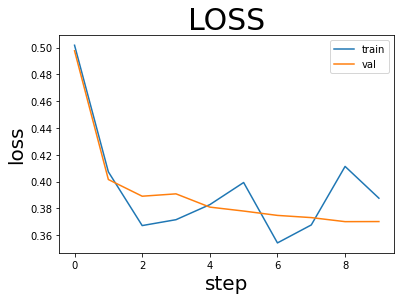

In [14]:
import matplotlib.pyplot as plt

total_step_list=np.arange(len(train_loss_list))
plt.plot(total_step_list,train_loss_list)
plt.plot(total_step_list,val_loss_list)
plt.title("LOSS",fontsize=30)
plt.xlabel('step',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.legend(['train','val'],loc='upper right')


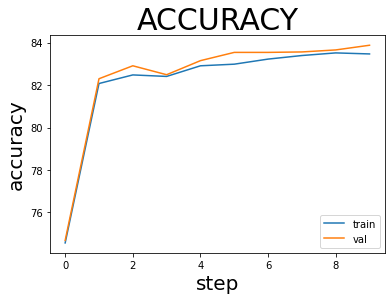

In [15]:

total_step_list=np.arange(len(train_acc_list))
plt.plot(total_step_list,train_acc_list)
plt.plot(total_step_list,val_acc_list)
plt.title("ACCURACY",fontsize=30)
plt.xlabel('step',fontsize=20)
plt.ylabel('accuracy',fontsize=20)
plt.legend(['train','val'],loc='lower right')


In [17]:
print("Test Accuracy : ",evaluate(X_test,y_test)[1],"%")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy :  83.58413132694939 %
